### Set up

In [141]:
import pandas as pd
import numpy as np
import altair as alt
import glob
import os
import numpy as np
from scipy import fftpack
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
from scipy.signal import butter, filtfilt
import altair as alt
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as scipy_signal
import pywt

alt.data_transformers.disable_max_rows()
fs = 22050

### Load data

In [142]:
# Which fish?
subjid = 'hydrolagusColliei_8'

loaded = np.load(f'{subjid}_data.npz', allow_pickle=True)
data = loaded['data']
freq_amp_table = loaded['freq_amp_table']
latency = loaded['latency'].item()
channel_keys = loaded['channel_keys'].tolist()

data

array({(np.float64(55.0), np.float64(115.0)): {'filename': 'data\\hydrolagusColliei_8_AdaptiveAEP_Ratfish_2506211524_1_run.mat', 'decision': array([[1.]]), 'period_len': 3528, 'ch1': array([[ 1.13919523,  0.29854812,  0.51171346, ...,  0.24535885,
         0.71333113,  0.17893058],
       [-0.53218433, -0.06263737,  0.94265154, ..., -0.704058  ,
         1.99663896,  3.66895166],
       [ 2.37567084,  1.16514833,  0.0586715 , ..., -1.92881097,
        -1.78592312, -0.78063422],
       ...,
       [ 0.52711035, -1.10291921, -1.87754631, ..., -0.50617291,
        -0.01370557, -0.80273809],
       [ 0.82851623,  0.15274419,  0.2325281 , ...,  1.65131694,
         1.86232438,  0.56490273],
       [ 2.03851384,  2.79068714,  2.93614113, ..., -1.96881957,
        -0.88677948, -1.29520543]], shape=(100, 10584)), 'ch2': array([[ 1.83689618,  1.50323847,  1.31520973, ..., -0.0951808 ,
        -0.09308123, -0.0600129 ],
       [-0.06205415,  0.44131932,  0.61360124, ...,  1.10729333,
         1.

In [143]:
data.item()[100,115]

{'filename': 'data\\hydrolagusColliei_8_AdaptiveAEP_Ratfish_2506211524_1_run.mat',
 'decision': array([[1.]]),
 'period_len': 3528,
 'ch1': array([[ 0.23013692, -0.48733504, -0.26425503, ..., -0.41326665,
         -1.00861324,  0.38958809],
        [ 0.55119716,  0.25609001, -1.12729763, ...,  1.33223963,
          1.1077599 ,  1.18089515],
        [-0.07535147,  0.8187182 ,  1.85217643, ..., -0.31861074,
         -0.50827248,  0.68726138],
        ...,
        [ 0.92643814, -0.15770153,  0.01143103, ...,  1.28814852,
          0.65827556, -1.04471429],
        [ 1.53269087,  1.38997798,  1.94624912, ...,  1.19010996,
          1.02331027,  0.22232183],
        [ 1.45973058, -0.39162934,  0.05342256, ...,  0.85551911,
          0.50139054,  0.88940395]], shape=(100, 10584)),
 'ch2': array([[-1.38093814, -1.20655664, -1.14117816, ...,  0.03172693,
          0.08777396,  0.18108848],
        [ 0.76803676,  0.62427409,  0.33972315, ..., -0.10579533,
          0.16009271,  0.4655811 ],
   

### What stimulus frequencies and amplitudes were tested for this fish?

In [144]:
freq_amp_table_df = pd.DataFrame(freq_amp_table).sort_values(by= [0,1],ascending=True)
print(list(data.item().keys()))
freq_amp_table_df

[(np.float64(55.0), np.float64(115.0)), (np.float64(55.0), np.float64(110.0)), (np.float64(55.0), np.float64(105.0)), (np.float64(55.0), np.float64(100.0)), (np.float64(55.0), np.float64(95.0)), (np.float64(220.0), np.float64(125.0)), (np.float64(220.0), np.float64(120.0)), (np.float64(220.0), np.float64(115.0)), (np.float64(220.0), np.float64(110.0)), (np.float64(220.0), np.float64(105.0)), (np.float64(220.0), np.float64(100.0)), (np.float64(220.0), np.float64(95.0)), (np.float64(220.0), np.float64(90.0)), (np.float64(880.0), np.float64(150.0)), (np.float64(880.0), np.float64(140.0)), (np.float64(100.0), np.float64(115.0)), (np.float64(100.0), np.float64(110.0)), (np.float64(100.0), np.float64(105.0)), (np.float64(100.0), np.float64(100.0)), (np.float64(440.0), np.float64(150.0)), (np.float64(1695.0), np.float64(150.0)), (np.float64(330.0), np.float64(150.0)), (np.float64(360.0), np.float64(150.0)), (np.float64(385.0), np.float64(150.0)), (np.float64(55.0), np.float64(90.0)), (np.floa

,0,1
30,55.0,90.0
4,55.0,95.0
29,55.0,95.0
3,55.0,100.0
28,55.0,100.0
2,55.0,105.0
27,55.0,105.0
1,55.0,110.0
26,55.0,110.0
0,55.0,115.0


### Artefact rejection

In [145]:
for coord, dictionary in data.item().items():
    for channel in ['ch1', 'ch2', 'ch3', 'ch4']:
        rms_per_row = np.sqrt(np.mean(dictionary[channel]**2, axis=1))  # Get RMS of each row, axis = 1 means collapse rows
        rms_mean = np.mean(rms_per_row)
        rms_std = np.std(rms_per_row)
        
        # See which rows has an rms that is too high (i.e., artifact) and remove them
        threshold = rms_mean + (rms_std*3)
        keep_rows = rms_per_row <= threshold
        dictionary[channel] = dictionary[channel][keep_rows]
        dictionary[f'{channel}_total_trials'] = dictionary[channel].shape[0]

### Make sure each channel has same number of trials after artefact rejection

In [146]:
for coord, dictionary in data.item().items():
    # Determine the minimum number of trials across all channels
    min_trials = min([dictionary[f'{channel}_total_trials'] for channel in ['ch1', 'ch2', 'ch3', 'ch4']])
    
    # Randomly select the same number of trials for each channel
    for channel in ['ch1', 'ch2', 'ch3', 'ch4']:
        # Set a random seed for reproducibility if needed
        np.random.seed(42)
        
        # Get indices for the channel
        channel_indices = np.arange(dictionary[channel].shape[0])
        
        # Randomly select indices
        selected_indices = np.random.choice(channel_indices, size=min_trials, replace=False)
        
        # Update the channel data with selected trials
        dictionary[channel] = dictionary[channel][selected_indices]
        
        # Update the total trials count
        dictionary[f'{channel}_total_trials'] = min_trials

In [147]:
dictionary

{'filename': 'data\\hydrolagusColliei_8_AdaptiveAEP_Ratfish_2506211524_1_run.mat',
 'decision': array([[0.]]),
 'period_len': 3528,
 'ch1': array([[ 1.0074468 ,  0.70125856,  0.48867644, ..., -1.89930026,
         -0.19881823,  0.95664872],
        [-1.12858071, -2.66453758, -2.59501827, ..., -0.44464365,
          0.07266868,  0.19409419],
        [-1.59742781, -1.88891902, -2.01769304, ...,  0.18382959,
          0.19450244,  0.08742403],
        ...,
        [-0.90223469,  0.49940761,  2.84020215, ...,  1.23256807,
          0.54839772,  0.73450186],
        [-2.11071595, -3.22279165, -2.10365904, ..., -2.71230295,
         -3.24396238, -2.14914986],
        [-0.2525324 , -0.675947  , -1.65656588, ...,  0.38999634,
          1.61527421,  2.28731366]], shape=(997, 10584)),
 'ch2': array([[-0.47345451, -0.46791396, -0.54950583, ...,  0.81311933,
          0.53988278,  0.37891524],
        [ 1.40601642,  1.51402796,  1.60938373, ...,  1.50224701,
          1.26516982,  1.17879558],
   

### Get data for responses to single stimulus type (frequency,amplitude)

## Select Stimulus

In [148]:
# Select which stimulus frequency and amplitude to analyze
myfreq = 100
myamp = 115

specific_key = (np.float64(myfreq), np.float64(myamp))
current_cond = data.item()[specific_key]
current_cond

{'filename': 'data\\hydrolagusColliei_8_AdaptiveAEP_Ratfish_2506211524_1_run.mat',
 'decision': array([[1.]]),
 'period_len': 3528,
 'ch1': array([[-1.90478248, -0.51013877,  0.21818099, ..., -2.41159693,
         -2.18233484, -2.44676484],
        [-1.58028127, -1.89125188, -2.32329807, ...,  1.50300519,
          0.95915654,  0.26326357],
        [ 0.31464487,  1.88332015,  1.77560021, ...,  2.01815962,
          0.11296888,  0.54180739],
        ...,
        [ 0.20774143,  0.61126838,  0.08240838, ..., -0.78255883,
         -0.42236481, -0.52005344],
        [-0.26396343,  0.88724605,  1.26785262, ..., -2.68232566,
         -3.72301576, -3.28828677],
        [-1.58547189, -0.70884036, -0.21987232, ...,  1.940242  ,
          0.80577081, -0.96195598]], shape=(97, 10584)),
 'ch2': array([[ 0.62170794,  0.37623245,  0.09605563, ..., -0.30123091,
         -0.25264904, -0.26944565],
        [ 0.46412306,  0.9187397 ,  1.1891185 , ..., -0.13419793,
         -0.29574868, -0.36054395],
    

### Wavelet or other signal processing technique here

### Reshape data for PCA/ICA

#### Separate by stimulus period

In [149]:
# Separate signal by stimulus period
prestim = [] # stimulus off
stimresp = [] # stimulus on

for channel in channel_keys:
    period_len = current_cond['period_len']
    prestim.append(current_cond[channel][:,latency:latency+period_len])
    stimresp.append(current_cond[channel][:,latency+period_len:latency+period_len*2]) 

In [150]:
# Get prestim and stimresp into PCA friendly format
# Reshape to channel x (trials x samples)

# prestim
# Get data from channel 1
X_prestim = prestim[0].reshape(1, -1).T
# Then get the rest of the channels
for channel in range(1,len(prestim)):
    tmp = prestim[channel].reshape(1, -1).T
    X_prestim = np.hstack([X_prestim, tmp])
    
# stimresp
# Get data from channel 1
X_stimresp = stimresp[0].reshape(1, -1).T
# Then get the rest of the channels
for channel in range(1,len(stimresp)):
    tmp = stimresp[channel].reshape(1, -1).T
    X_stimresp = np.hstack([X_stimresp, tmp])

# all periods
# Get data from channel 1
X_all_periods = current_cond['ch1'].reshape(1, -1).T
selected_keys = channel_keys[1:5]

# Then get the rest of the channels
for channel in selected_keys:
    tmp = current_cond[channel].reshape(1, -1).T
    X_all_periods = np.hstack([X_all_periods, tmp])

X_prestim
X_stimresp
X_all_periods

array([[-1.90478248,  0.62170794,  0.32514275, -1.20025792],
       [-0.51013877,  0.37623245,  0.86117631, -1.4568145 ],
       [ 0.21818099,  0.09605563,  2.01582675, -1.2464486 ],
       ...,
       [ 1.940242  ,  1.20632336,  1.2429493 ,  2.15469041],
       [ 0.80577081,  1.01135435,  0.3133618 ,  0.30782125],
       [-0.96195598,  0.88228871, -0.11611825, -0.89476953]],
      shape=(1026648, 4))

In [151]:
# Create dictionary to store the three datasets
data_dict = {
    'prestim': X_prestim,
    'stimresp': X_stimresp,
    'all_periods': X_all_periods
}

### PCA

In [152]:
data

array({(np.float64(55.0), np.float64(115.0)): {'filename': 'data\\hydrolagusColliei_8_AdaptiveAEP_Ratfish_2506211524_1_run.mat', 'decision': array([[1.]]), 'period_len': 3528, 'ch1': array([[ 0.88316354, -1.10204439, -0.70989015, ...,  1.01613672,
         0.15501873, -0.6253822 ],
       [ 1.82511522,  1.08944693,  0.56391126, ..., -0.14551232,
        -0.25772302, -1.05941132],
       [ 0.56927685,  2.16378858,  2.48362407, ..., -0.72295418,
        -0.93454484, -1.14963479],
       ...,
       [ 0.19934313, -0.81125304, -1.08460624, ..., -0.51754561,
        -0.38165636, -0.9603813 ],
       [-0.19053657, -0.72155447,  1.09860342, ..., -0.68965257,
        -1.49064101, -0.34438887],
       [-0.84863717, -2.05146123, -1.87882938, ...,  0.29464057,
         0.71665545,  0.84566277]], shape=(97, 10584)), 'ch2': array([[-1.63994423, -1.85200146, -2.00083811, ..., -1.63288732,
        -1.85835851, -1.88145386],
       [ 0.51287989,  0.48855979,  0.33534903, ...,  0.27125362,
         0.4

prestim:
Explained variance ratio: [0.5074307  0.20761111 0.17099525 0.11396294]
stimresp:
Explained variance ratio: [0.5141591  0.20455931 0.16810316 0.11317843]
all_periods:
Explained variance ratio: [0.52595307 0.19656613 0.16238827 0.11509253]


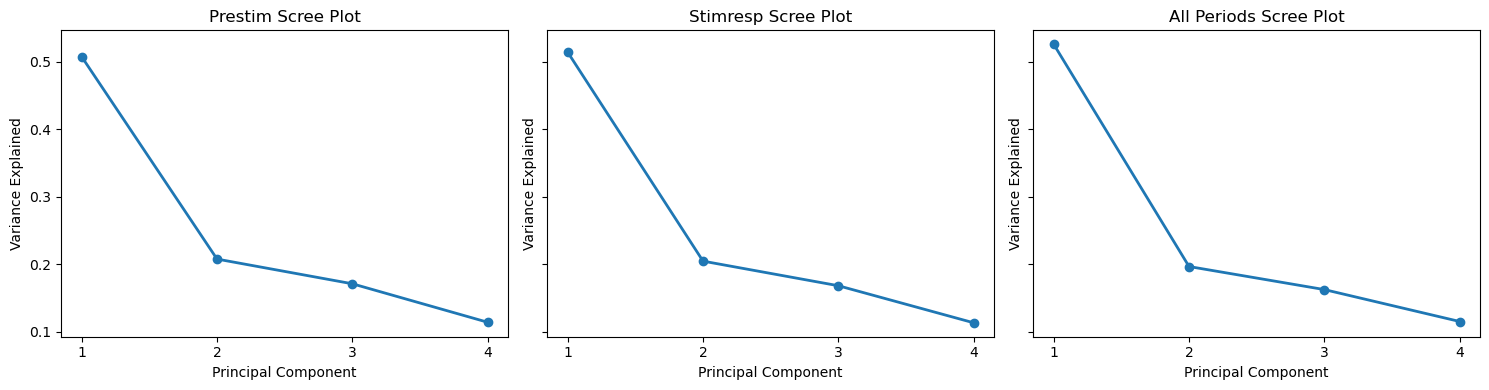

In [153]:
# Set up for scree plots
fig, axs = plt.subplots(1, 3, figsize=(15, 4),sharey=True)

# Dictionary to store PCA results
pca_results = {}

# Loop through datasets and create scree plots
for idx, (name, data) in enumerate(data_dict.items()):
    # Fit PCA
    pca = PCA(n_components=len(channel_keys))
    X_pca = pca.fit_transform(data)
    
    # Store PCA results in dictionary
    pca_results[name] = {
        'pca_model': pca,
        'transformed_data': X_pca,
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'components': pca.components_
    }
    
    # Plot scree plot in corresponding subplot
    PC_values = np.arange(pca.n_components_) + 1
    axs[idx].plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2)
    axs[idx].set_title(f'{name.replace("_", " ").title()} Scree Plot')
    axs[idx].set_xlabel('Principal Component')
    axs[idx].set_ylabel('Variance Explained')
    
    # Remove decimal points from x-axis
    axs[idx].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    # Print explained variance for reference
    print(f'{name}:')
    print("Explained variance ratio:", pca.explained_variance_ratio_)
    
# Adjust layout and save figure
plt.tight_layout()
plt.savefig(f'{subjid}_{myfreq}Hz_{myamp}dB_scree_plots.png', dpi=300, bbox_inches='tight')
plt.show()

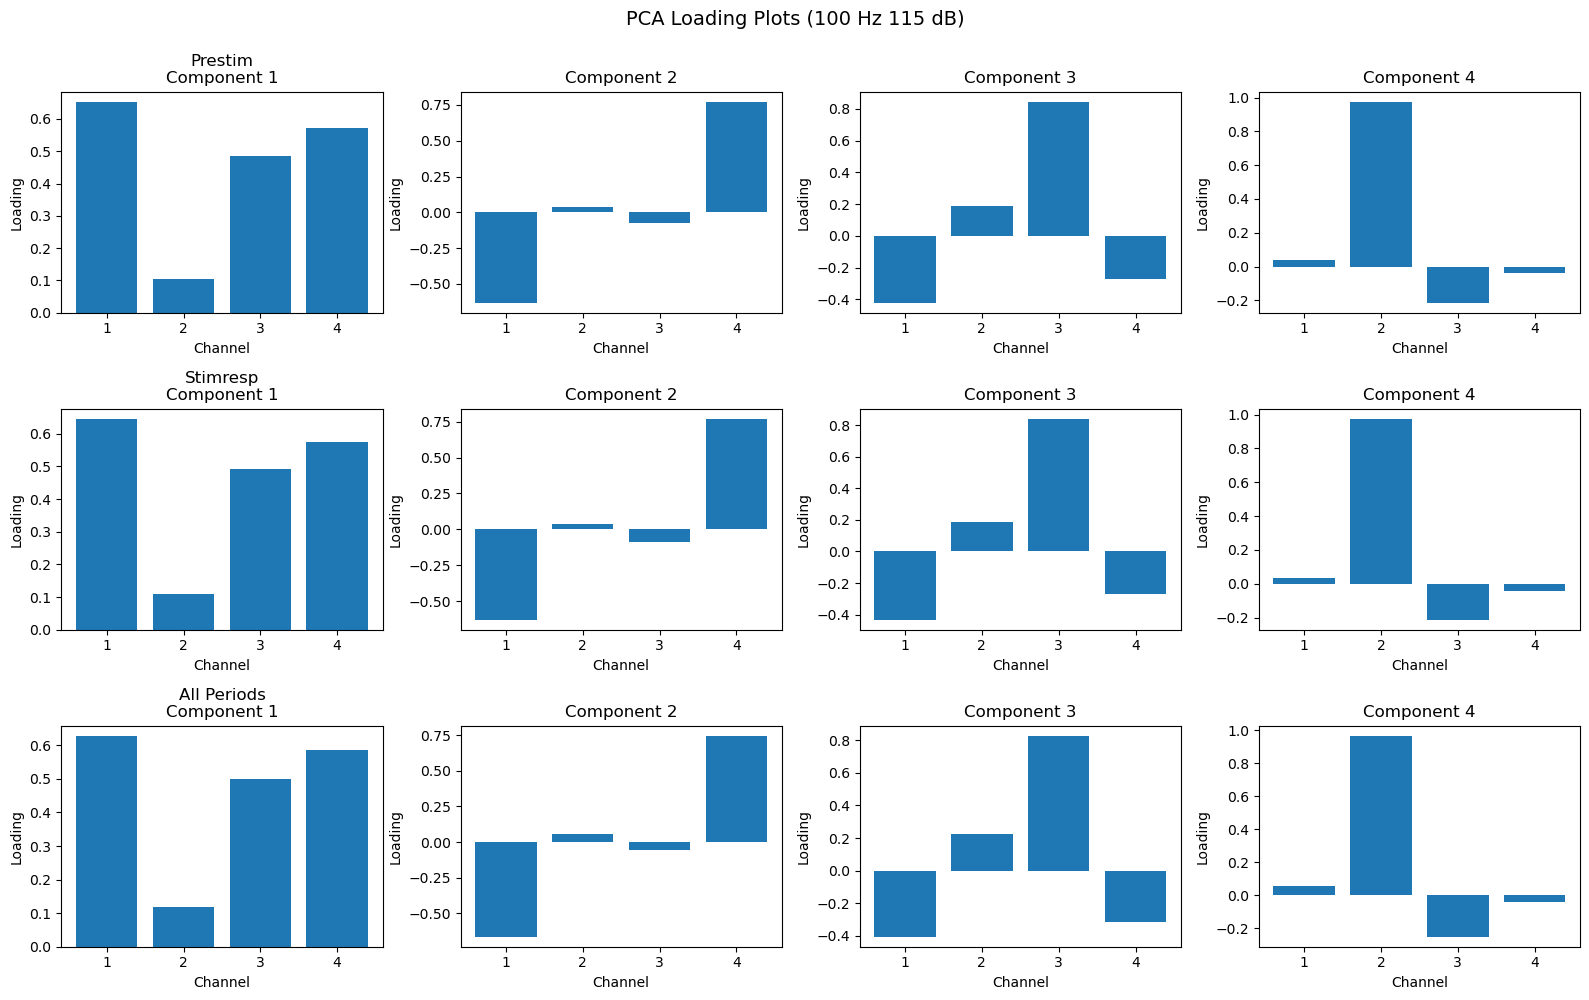

In [154]:
# Create figure with 3x4 grid for loading plots
fig, axs = plt.subplots(3, 4, figsize=(16, 10))

# Loop through each dataset
for row_idx, (name, pca_data) in enumerate(pca_results.items()):
    components = pca_data['components']
    
    # Loop through each component
    for col_idx, comp in enumerate(components):
        axs[row_idx, col_idx].bar(range(1, 5), comp)
        axs[row_idx, col_idx].set_xlabel("Channel")
        axs[row_idx, col_idx].set_ylabel("Loading")
        
        # Add title with dataset name on first component, component number on all
        if col_idx == 0:
            axs[row_idx, col_idx].set_title(f"{name.replace('_', ' ').title()}\nComponent {col_idx+1}")
        else:
            axs[row_idx, col_idx].set_title(f"Component {col_idx+1}")

# Add overall title and save
fig.suptitle(f'PCA Loading Plots ({myfreq} Hz {myamp} dB)', fontsize=14, y=0.995)
plt.tight_layout()
plt.savefig(f'{subjid}_{myfreq}Hz_{myamp}dB_loading_plots.png', dpi=300, bbox_inches='tight')
plt.show()

In [155]:
pca_results

{'prestim': {'pca_model': PCA(n_components=4),
  'transformed_data': array([[ 2.90185277, -0.52732899,  0.76487794,  0.66945629],
         [ 0.64697179, -1.41749221,  0.89947894,  1.04358123],
         [ 0.22452785, -0.50612271,  2.23014341,  1.01067355],
         ...,
         [-1.68693607,  0.68123361, -1.03875823,  1.00036316],
         [-2.44713274,  0.36047729, -0.46945013,  1.06730761],
         [-2.46305777,  0.22727258,  0.13470653,  0.92861337]],
        shape=(342216, 4)),
  'explained_variance_ratio': array([0.5074307 , 0.20761111, 0.17099525, 0.11396294]),
  'components': array([[ 0.65148794,  0.10455284,  0.48666208,  0.57253138],
         [-0.63042221,  0.03726306, -0.07226333,  0.77198272],
         [-0.42050688,  0.18992998,  0.84395675, -0.27356458],
         [ 0.03612843,  0.97550334, -0.2137172 , -0.03758891]])},
 'stimresp': {'pca_model': PCA(n_components=4),
  'transformed_data': array([[ 0.15891232, -0.50815583,  2.19738879, -0.35683037],
         [ 0.3727737 ,  0

#### Apply Butterworth filter

Apply different butterworth filters, and see what happens and compare to one another

In [156]:
# Create dictionary to store the three datasets
data_dict = {
    'prestim': X_prestim,
    'stimresp': X_stimresp,
    'all_periods': X_all_periods
}

In [157]:
bandpass_widths = [(1/4),(1/3),(1/2),(1),(2),(3)]
ica_results = {}
timing_convergence = {}

def bandpass(data, low, high, fs, order=4):
        ny = 0.5 * fs
        b, a = butter(order, [low/ny, high/ny], btype='band')
        return filtfilt(b, a, data, axis=0)

for mybandwidth in bandpass_widths:
    start = time.perf_counter()
    
    # low, high = (myfreq*2-myfreq), (myfreq+myfreq*2)
    center_freq = myfreq*2
    low = center_freq/(2**(mybandwidth/2))
    high = center_freq*(2**(mybandwidth/2))

    # X_all_periods: shape (n_samples, n_channels)
    X_prestim_filtered = bandpass(X_prestim, low, high, fs)
    X_all_filtered = bandpass(X_all_periods, low, high, fs)

    # Preprocessing: Standardize the data
    scaler = StandardScaler()

    # filtered version
    X_prestim_scaled = scaler.fit_transform(X_prestim_filtered)
    X_all_scaled = scaler.fit_transform(X_all_filtered)

    # Improved FastICA configuration
    ica = FastICA(
        n_components=len(channel_keys), 
        random_state=42,  # More robust random seed
        max_iter=500,     # Increased iterations
        tol=1e-4,         # Tightened tolerance???
        whiten='unit-variance'  # Corrected whiten parameter
    )

    # # Fit and transform
    # ica.fit(X_prestim_scaled)
    # S = ica.transform(X_all_scaled)
    # A = ica.mixing_
    
    # Fit and transform (don't do a hybrid)
    S = ica.fit_transform(X_all_scaled)
    A = ica.mixing_

    end = time.perf_counter()
    elasped = end - start
    
    # Convergence check
    print(f"{mybandwidth}")
    print(f"Elapsed time: {elasped:.2f} seconds")
    print(f"ICA Convergence: {ica.n_iter_}")
    
    # Store results in dictionary
    ica_results[mybandwidth] = {
        'S': S,
        'A': A,
        'n_iter': ica.n_iter_,
        'X_prestim_filtered': X_prestim_filtered,
        'X_all_filtered': X_all_filtered,
        'elapsed_time': elasped
    }

    timing_convergence[mybandwidth] = {
        'elapsed_time': elasped,
        'n_iter': ica.n_iter_
    }

0.25
Elapsed time: 2.06 seconds
ICA Convergence: 14
0.3333333333333333
Elapsed time: 1.94 seconds
ICA Convergence: 13
0.5
Elapsed time: 2.26 seconds
ICA Convergence: 16
1
Elapsed time: 4.02 seconds
ICA Convergence: 33
2
Elapsed time: 1.06 seconds
ICA Convergence: 4
3
Elapsed time: 1.40 seconds
ICA Convergence: 7


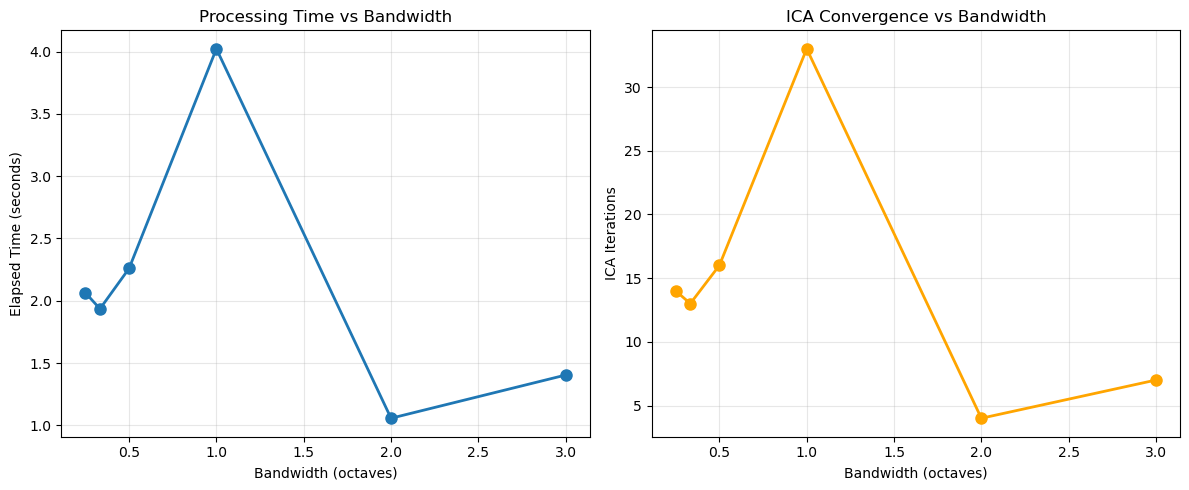

In [158]:
# Extract data for plotting
bandwidths = list(timing_convergence.keys())
elapsed_times = [timing_convergence[bw]['elapsed_time'] for bw in bandwidths]
n_iters = [timing_convergence[bw]['n_iter'] for bw in bandwidths]

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Elapsed time vs bandwidth
ax1.plot(bandwidths, elapsed_times, marker='o', linewidth=2, markersize=8)
ax1.set_xlabel('Bandwidth (octaves)')
ax1.set_ylabel('Elapsed Time (seconds)')
ax1.set_title('Processing Time vs Bandwidth')
ax1.grid(True, alpha=0.3)

# Plot 2: ICA convergence vs bandwidth
ax2.plot(bandwidths, n_iters, marker='o', linewidth=2, markersize=8, color='orange')
ax2.set_xlabel('Bandwidth (octaves)')
ax2.set_ylabel('ICA Iterations')
ax2.set_title('ICA Convergence vs Bandwidth')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Plot IC Waveforms by Bandwidth

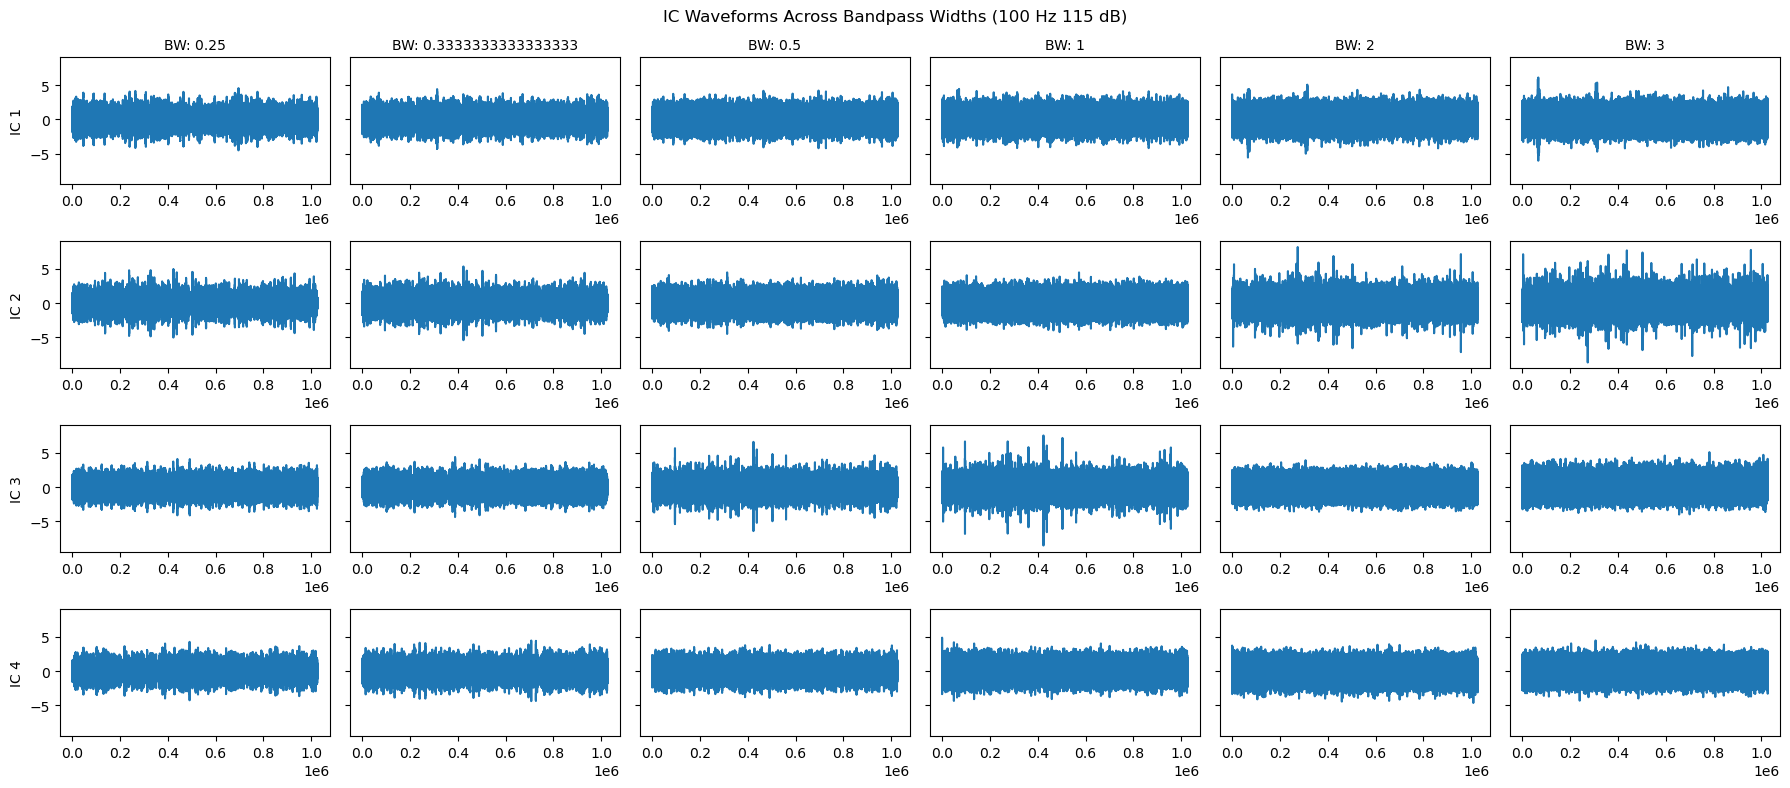

In [159]:
# Create subplot grid: 4 rows (ICs) x len(bandpass_widths) columns
fig, axes = plt.subplots(4, len(bandpass_widths), figsize=(len(bandpass_widths)*3, 8), sharey=True)

# Iterate through bandpass widths (columns) and ICs (rows)
for col_idx, mybandwidth in enumerate(bandpass_widths):
    # Get the S matrix for this bandpass width
    S = ica_results[mybandwidth]['S']
    
    # Plot each of the first 4 ICs
    for row_idx in range(4):
        ax = axes[row_idx, col_idx]
        ax.plot(S[:, row_idx])
        
        # Add column title on top row
        if row_idx == 0:
            ax.set_title(f'BW: {mybandwidth}', fontsize=10)
        
        # Add row label on first column
        if col_idx == 0:
            ax.set_ylabel(f'IC {row_idx+1}', fontsize=10)

# Add overall title
fig.suptitle(f'IC Waveforms Across Bandpass Widths ({myfreq} Hz {myamp} dB)', fontsize=12)
plt.tight_layout()
plt.savefig(f'{subjid}_{myfreq}Hz_{myamp}dB_chart13.png', dpi=300, bbox_inches='tight')
plt.show()

### Calculate FFT of each IC

In [160]:
# Dictionary to store FFT results
fft_results = {}

# Iterate through all bandpass widths
for mybandwidth in bandpass_widths:
    # Get the S matrix for this bandpass width
    S = ica_results[mybandwidth]['S']
    
    # Calculate FFT parameters
    n_samples = len(S)
    freqs = np.fft.rfftfreq(n_samples, d=1/fs)
    
    # Calculate power spectrum for each IC
    power_spectra = []
    for i in range(4):  # first 4 ICs
        fft_vals = np.fft.rfft(S[:, i])
        power = np.abs(fft_vals) ** 2
        power_spectra.append(power)
    
    # Convert to array
    power_spectra = np.array(power_spectra)  # shape: (4, n_freqs)
    
    # Store results
    fft_results[mybandwidth] = {
        'freqs': freqs,
        'power_spectra': power_spectra
    }

### Plot FFT results

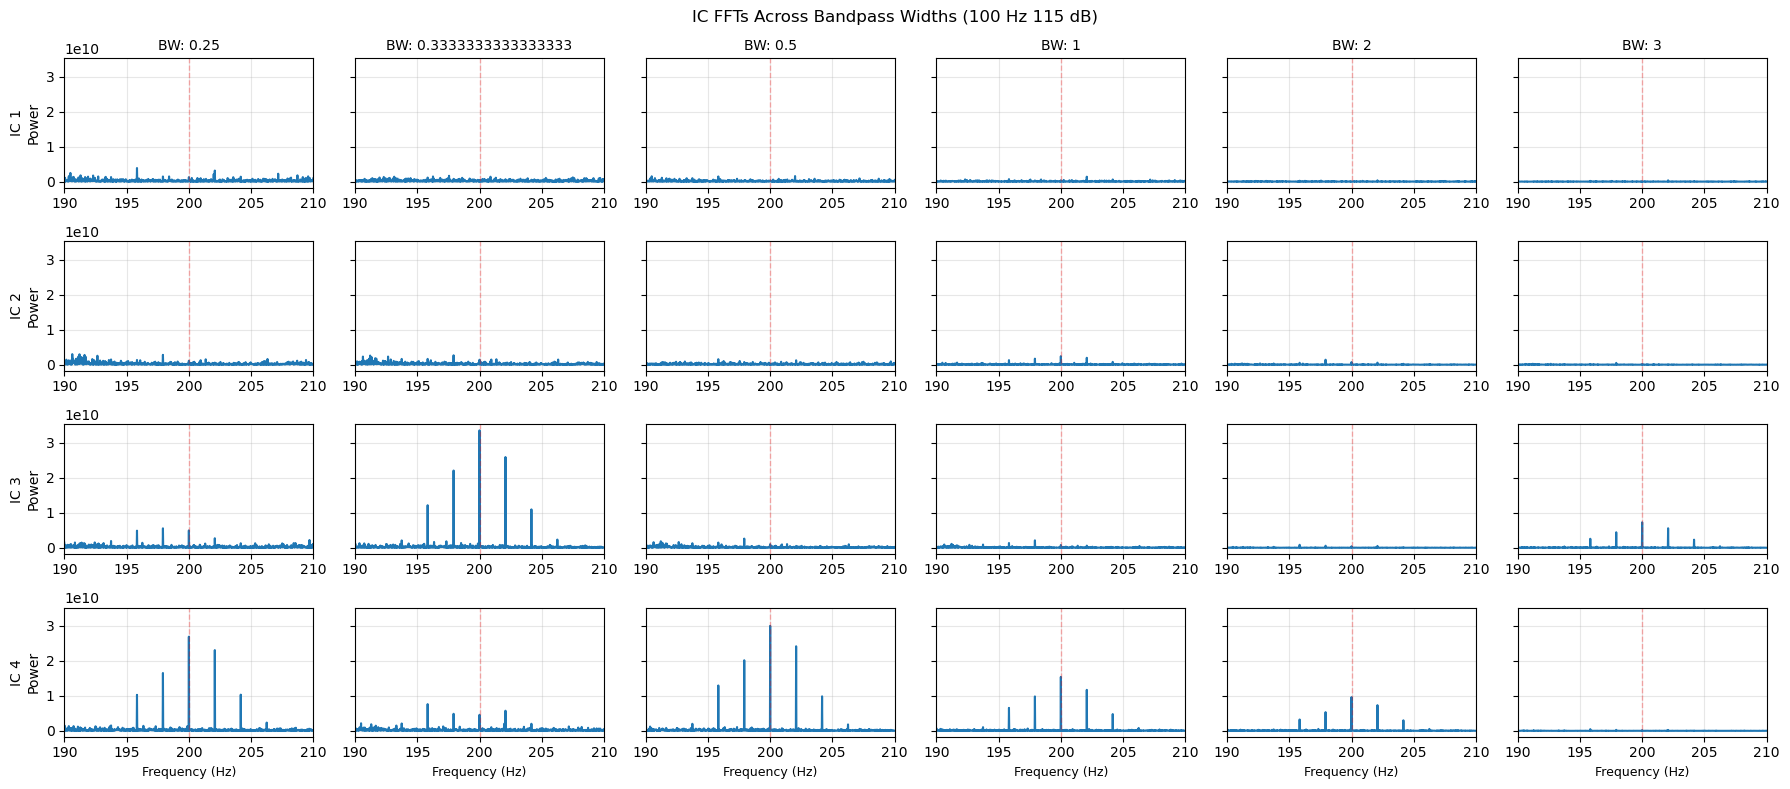

In [161]:
# Create subplot grid: 4 rows (ICs) x len(bandpass_widths) columns
fig, axes = plt.subplots(4, len(bandpass_widths), figsize=(len(bandpass_widths)*3, 8), sharey=True)

# Iterate through ICs (rows) and bandpass widths (columns)
for row_idx in range(4):  # 4 ICs
    for col_idx, mybandwidth in enumerate(bandpass_widths):
        ax = axes[row_idx, col_idx]
        
        # Get FFT results for this bandwidth
        freqs = fft_results[mybandwidth]['freqs']
        power_spectra = fft_results[mybandwidth]['power_spectra']
        
        # Plot the power spectrum for this IC
        ax.plot(freqs, power_spectra[row_idx])
        
        # Calculate center frequency for this bandwidth
        center_freq = myfreq * 2
        ax.axvline(x=center_freq, color='r', linestyle='--', linewidth=1, alpha=0.3)
        
        # Add column title on top row
        if row_idx == 0:
            ax.set_title(f'BW: {mybandwidth}', fontsize=10)
        
        # Add row label on first column
        if col_idx == 0:
            ax.set_ylabel(f'IC {row_idx+1}\nPower', fontsize=10)
        
        # Add x-label on bottom row
        if row_idx == 3:
            ax.set_xlabel('Frequency (Hz)', fontsize=9)
        
        ax.set_xlim(center_freq-center_freq*0.05, center_freq+center_freq*0.05)
        ax.grid(True, alpha=0.3)

fig.suptitle(f'IC FFTs Across Bandpass Widths ({myfreq} Hz {myamp} dB)', fontsize=12)
plt.tight_layout()
plt.savefig(f'{subjid}_{myfreq}Hz_{myamp}dB_chart14.png', dpi=300, bbox_inches='tight')
plt.show()

### Plot wavelet spectrogram of each IC

#### Reconstruct the wavelet spectrogram

In [162]:

# # Reconstruct the signals
# X_reconstructed = S @ A.T

# Select which bandwidth to use
S = ica_results[1]['S']

# Extract each channel and reshape to original dimensions
n_trials = current_cond['ch1'].shape[0]
n_samples_per_trial = current_cond['ch1'].shape[1]

ch1_recon = S[:, 0].reshape(n_trials, n_samples_per_trial)
ch2_recon = S[:, 1].reshape(n_trials, n_samples_per_trial)
ch3_recon = S[:, 2].reshape(n_trials, n_samples_per_trial)
ch4_recon = S[:, 3].reshape(n_trials, n_samples_per_trial)

# Create denoised dataset with same structure
recon_data = {
    'filename': current_cond['filename'],
    'decision': current_cond['decision'],
    'period_len': current_cond['period_len'],
    'ch1': ch1_recon,
    'ch2': ch2_recon,
    'ch3': ch3_recon,
    'ch4': ch4_recon
}


### Continuous Wavelet Analysis of ICs

Starting CWT computation...
CWT calculation time for ch1: 10.14 seconds
Starting CWT computation...
CWT calculation time for ch2: 12.02 seconds
Starting CWT computation...
CWT calculation time for ch3: 15.59 seconds
Starting CWT computation...
CWT calculation time for ch4: 14.55 seconds
CWT calculated for channels: ['ch1', 'ch2', 'ch3', 'ch4']


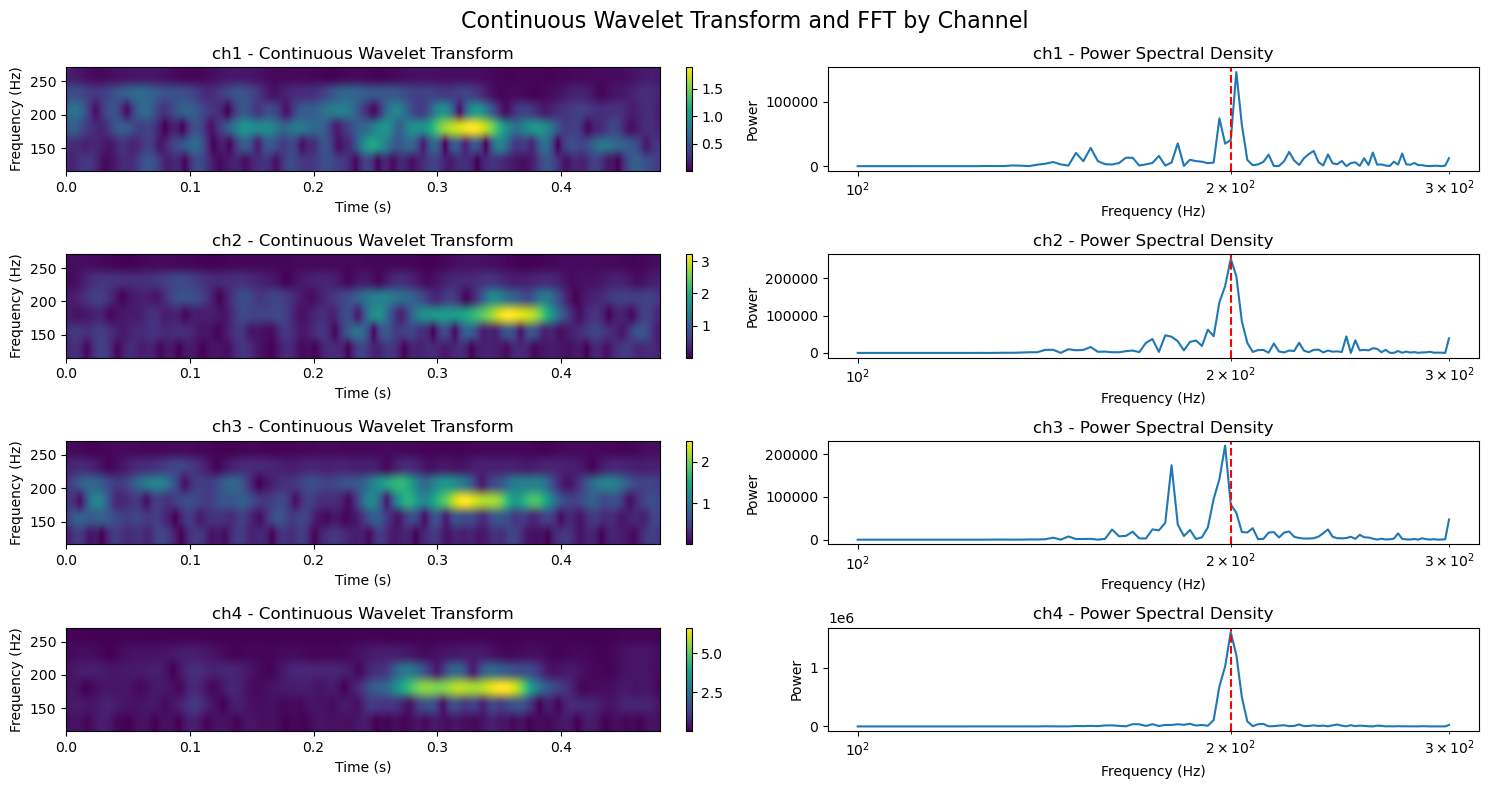

In [178]:
# --- Setup and Parameters ---

sig_len = ch1_recon.shape[1]
max_scale = 2 ** np.floor(np.log2(sig_len / 2))  # Main change

# Continuous Wavelet Transform (CWT) parameters
scale = np.geomspace(1, max_scale, num=50)  # Logarithmic scales (Torrence & Compo)
downsample_factor = 1
wav_fs = fs / downsample_factor
dt = 1 / wav_fs  # Sampling period (inverse of sampling rate)
wavelet = "cmor2.5-1.5"

# --- Initialize Storage Dictionaries ---

recon_dict = {}
cwt_dict = {}

# --- Compute Mean, STD, and CWT per Channel ---

for channel in channel_keys:
    cur_clean = recon_data[channel]
    recon_mean = np.mean(cur_clean, axis=0)
    recon_std = np.std(cur_clean, axis=0)

    recon_dict[f"{channel}_mean"] = recon_mean
    recon_dict[f"{channel}_std"] = recon_std

    print("Starting CWT computation...")
    start_time = time.time()

    coeffs, scales_used = pywt.cwt(recon_mean, scale, wavelet, sampling_period=dt)
    coeffs = np.abs(coeffs)

    cwt_dict[channel] = {
        "coeffs": coeffs,  # shape: (n_scales, n_samples)
        "freqs": pywt.scale2frequency(wavelet, scales_used) / dt
    }

    end_time = time.time()
    print(f"CWT calculation time for {channel}: {end_time - start_time:.2f} seconds")

print("CWT calculated for channels:", list(cwt_dict.keys()))

# --- Plot Configuration ---

x_min, x_max = 100, 300
n_channels = len(channel_keys)

fig, axes = plt.subplots(n_channels, 2, figsize=(15, 2 * n_channels))
fig.suptitle("Continuous Wavelet Transform and FFT by Channel", fontsize=16)

# --- Plot per Channel ---

for i, channel in enumerate(channel_keys):
    # Retrieve CWT results
    coeffs = cwt_dict[channel]["coeffs"]
    freqs = cwt_dict[channel]["freqs"]

    # Compute FFT
    cur_clean = recon_data[channel]
    recon_mean = scipy_signal.decimate(np.mean(cur_clean, axis=0), downsample_factor)

    cwt_mask = (freqs >= x_min) & (freqs <= x_max)
    freq_indices = np.where(cwt_mask)[0]
    filtered_coeffs = coeffs[freq_indices, :]
    filtered_freqs = freqs[freq_indices]

    fft_vals = np.fft.fft(recon_mean)
    fft_freq = np.fft.fftfreq(len(recon_mean), d=dt)

    fft_mask = (fft_freq >= x_min) & (fft_freq <= x_max) & (fft_freq > 0)
    filtered_fft_freq = fft_freq[fft_mask]
    filtered_fft_vals = np.abs(fft_vals[fft_mask]) ** 2

    # --- Plot CWT ---
    im = axes[i, 0].imshow(
        filtered_coeffs,
        aspect="auto",
        origin="lower",
        extent=[0, len(recon_mean) * dt, filtered_freqs[0], filtered_freqs[-1]],
        cmap="viridis",
    )
    axes[i, 0].set_title(f"{channel} - Continuous Wavelet Transform")
    axes[i, 0].set_xlabel("Time (s)")
    axes[i, 0].set_ylabel("Frequency (Hz)")
    plt.colorbar(im, ax=axes[i, 0], fraction=0.046, pad=0.04)

    # --- Plot FFT ---
    axes[i, 1].plot(filtered_fft_freq, filtered_fft_vals)
    axes[i, 1].set_title(f"{channel} - Power Spectral Density")
    axes[i, 1].set_xlabel("Frequency (Hz)")
    axes[i, 1].set_ylabel("Power")
    axes[i, 1].set_xscale("log")
    axes[i, 1].axvline(x=center_freq, color="r", linestyle="--", label="Center Frequency")

plt.tight_layout()
plt.show()


### FFT vals

In [179]:
# Dictionary to store FFT results
fft_results = {}
recon_dict = {mybandwidth: {} for mybandwidth in bandpass_widths}

# Iterate through all bandpass widths
for mybandwidth in bandpass_widths:
    # Get the S matrix for this bandpass width
    S = ica_results[mybandwidth]['S']
    
    # Extract each channel and reshape to original dimensions
    n_trials = current_cond['ch1'].shape[0]
    n_samples_per_trial = current_cond['ch1'].shape[1]
 
    ch1_recon = S[:, 0].reshape(n_trials, n_samples_per_trial)
    ch2_recon = S[:, 1].reshape(n_trials, n_samples_per_trial)
    ch3_recon = S[:, 2].reshape(n_trials, n_samples_per_trial)
    ch4_recon = S[:, 3].reshape(n_trials, n_samples_per_trial)
    
    channel_reconstructions = {
        'ch1': ch1_recon,
        'ch2': ch2_recon,
        'ch3': ch3_recon,
        'ch4': ch4_recon
    }
    
    for channel in channel_keys:
        # Use the actual reconstructed channel data
        cur_recon = channel_reconstructions[channel]
        
        # Compute mean and standard deviation across trials
        recon_mean = np.mean(cur_recon, axis=0)
        recon_std = np.std(cur_recon, axis=0)
        
        recon_dict[mybandwidth][f"{channel}_mean"] = recon_mean
        recon_dict[mybandwidth][f"{channel}_std"] = recon_std
        
        # Compute FFT of the mean signal
        fft_mean_vals = np.fft.fft(recon_mean)
        
        # Compute FFT of the standard deviation signal
        fft_std_vals = np.fft.fft(recon_std)
        
        # Compute frequency array (only need to do this once)
        fft_freq = np.fft.fftfreq(len(recon_mean), d=1/fs)
        
        # Store power spectra (magnitude squared)
        recon_dict[mybandwidth][f"{channel}_mean_fft"] = np.abs(fft_mean_vals)**2
        recon_dict[mybandwidth][f"{channel}_std_fft"] = np.abs(fft_std_vals)**2
        recon_dict[mybandwidth][f"{channel}_fft_freq"] = fft_freq

In [180]:
ica_results

{0.25: {'S': array([[ 4.11278768e-02, -4.75670612e-01, -7.05267959e-01,
          -6.87309734e-01],
         [ 3.76246541e-02, -3.97065730e-01, -6.11395884e-01,
          -7.06102013e-01],
         [ 3.37971420e-02, -3.17262834e-01, -5.15388774e-01,
          -7.22203514e-01],
         ...,
         [-1.14844629e-04,  7.43615481e-05,  1.71699722e-05,
           2.05206236e-05],
         [-9.76952772e-05,  6.11634717e-05,  1.06616569e-05,
           1.81693114e-05],
         [-8.24279292e-05,  4.91904155e-05,  4.87103010e-06,
           1.60890727e-05]], shape=(1026648, 4)),
  'A': array([[ 0.4392759 , -0.24289007,  0.80765234,  0.30941685],
         [-0.3824665 , -0.80061339,  0.26994647,  0.37398727],
         [ 0.60370331, -0.74194209, -0.1884408 ,  0.22260797],
         [ 0.16264653, -0.31164154,  0.26105438, -0.89904186]]),
  'n_iter': 14,
  'X_prestim_filtered': array([[-8.32171929e-02, -2.47050102e-02, -5.22238054e-02,
          -1.74012940e-01],
         [-9.74069501e-02, -3.309

In [181]:
highest_magnitude_channels = {}

for mybandwidth in bandpass_widths:
    # Find the index of the center frequency
    freq_index = np.argmin(np.abs(recon_dict[mybandwidth]['ch1_fft_freq'] - center_freq))
    
    # Extract magnitudes for each channel using list comprehension and dictionary comprehension
    channel_magnitudes = {
        channel: {
            'mean_magnitude': recon_dict[mybandwidth][f"{channel}_mean_fft"][freq_index],
            'std_magnitude': recon_dict[mybandwidth][f"{channel}_std_fft"][freq_index]
        } for channel in channel_keys
    }
    
    # Find channels with highest magnitudes using max() with key functions
    highest_mean_channel = max(channel_magnitudes, key=lambda k: channel_magnitudes[k]['mean_magnitude'])
    highest_std_channel = max(channel_magnitudes, key=lambda k: channel_magnitudes[k]['std_magnitude'])
    
    # Store results
    highest_magnitude_channels[mybandwidth] = {
        'highest_mean_channel': highest_mean_channel,
        'highest_mean_magnitude': channel_magnitudes[highest_mean_channel]['mean_magnitude'],
        'highest_std_channel': highest_std_channel,
        'highest_std_magnitude': channel_magnitudes[highest_std_channel]['std_magnitude']
    }

# Print results with a more compact print format
for bandwidth, results in highest_magnitude_channels.items():
    print(f"Bandwidth: {bandwidth}")
    print(f"Highest Mean Magnitude Channel: {results['highest_mean_channel']} (Magnitude: {results['highest_mean_magnitude']:.2f})")
    print(f"Highest Std Magnitude Channel: {results['highest_std_channel']} (Magnitude: {results['highest_std_magnitude']:.2f})\n")

Bandwidth: 0.25
Highest Mean Magnitude Channel: ch4 (Magnitude: 2855466.54)
Highest Std Magnitude Channel: ch3 (Magnitude: 0.02)

Bandwidth: 0.3333333333333333
Highest Mean Magnitude Channel: ch3 (Magnitude: 3561309.50)
Highest Std Magnitude Channel: ch1 (Magnitude: 0.05)

Bandwidth: 0.5
Highest Mean Magnitude Channel: ch4 (Magnitude: 3184051.97)
Highest Std Magnitude Channel: ch4 (Magnitude: 0.17)

Bandwidth: 1
Highest Mean Magnitude Channel: ch4 (Magnitude: 1636179.59)
Highest Std Magnitude Channel: ch2 (Magnitude: 1.24)

Bandwidth: 2
Highest Mean Magnitude Channel: ch4 (Magnitude: 1022484.90)
Highest Std Magnitude Channel: ch4 (Magnitude: 1731.29)

Bandwidth: 3
Highest Mean Magnitude Channel: ch3 (Magnitude: 772984.89)
Highest Std Magnitude Channel: ch3 (Magnitude: 4856.96)



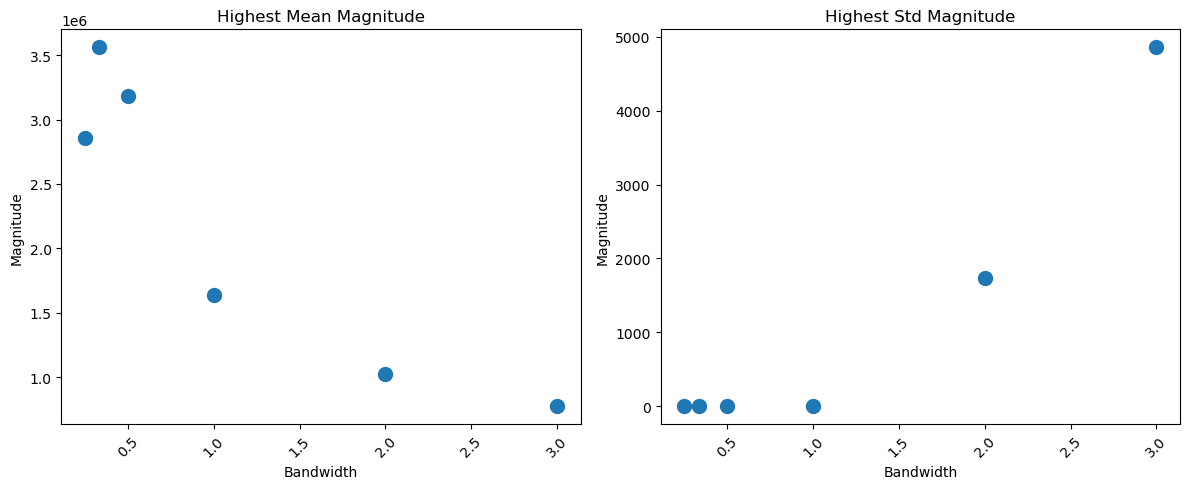

In [182]:
plt.figure(figsize=(12, 5))

# Mean Magnitudes
plt.subplot(1, 2, 1)
plt.scatter(
    list(highest_magnitude_channels.keys()), 
    [results['highest_mean_magnitude'] for results in highest_magnitude_channels.values()],
    s=100  # marker size
)
plt.title('Highest Mean Magnitude')
plt.xlabel('Bandwidth')
plt.ylabel('Magnitude')
plt.xticks(rotation=45)

# Std Magnitudes
plt.subplot(1, 2, 2)
plt.scatter(
    list(highest_magnitude_channels.keys()), 
    [results['highest_std_magnitude'] for results in highest_magnitude_channels.values()],
    s=100  # marker size
)
plt.title('Highest Std Magnitude')
plt.xlabel('Bandwidth')
plt.ylabel('Magnitude')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [183]:
recon_dict

{0.25: {'ch1_mean': array([0.02296958, 0.01995533, 0.01684996, ..., 0.03084861, 0.02819568,
         0.02542453], shape=(10584,)),
  'ch1_std': array([1.17182691, 1.17591277, 1.17936548, ..., 1.15635862, 1.16198416,
         1.16716388], shape=(10584,)),
  'ch1_mean_fft': array([1.46478222e-26, 7.28647576e-04, 7.92531772e-04, ...,
         7.45614718e-04, 7.92531772e-04, 7.28647576e-04], shape=(10584,)),
  'ch1_std_fft': array([1.07741007e+08, 6.71147509e+03, 5.49550563e+04, ...,
         1.13183152e+04, 5.49550563e+04, 6.71147509e+03], shape=(10584,)),
  'ch1_fft_freq': array([ 0.        ,  2.08333333,  4.16666667, ..., -6.25      ,
         -4.16666667, -2.08333333], shape=(10584,)),
  'ch2_mean': array([0.21067874, 0.21413224, 0.21694499, ..., 0.20381609, 0.20836799,
         0.21229394], shape=(10584,)),
  'ch2_std': array([1.22091296, 1.22609579, 1.23210935, ..., 1.20766435, 1.2105228 ,
         1.21435062], shape=(10584,)),
  'ch2_mean_fft': array([6.73334390e-26, 6.39526959e-02,

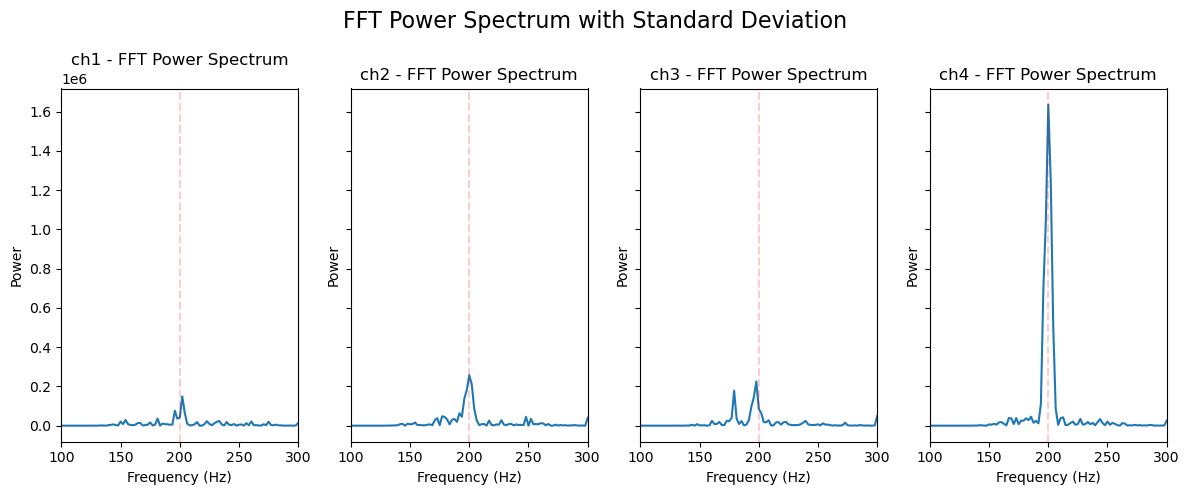

In [184]:
# Calculate frequency range based on center frequency
n_channels = len(channel_keys)
myband = 1 #### Select which bandwidth to use here
freq_buffer = 0.5 * center_freq
x_min = center_freq - freq_buffer
x_max = center_freq + freq_buffer

# Prepare figure
fig, axes = plt.subplots(1, n_channels, figsize=(3*n_channels, 5), sharex=True, sharey=True)
fig.suptitle('FFT Power Spectrum with Standard Deviation', fontsize=16)

# Prepare to store plot data for each channel
for i, channel in enumerate(channel_keys):
    # Get FFT data from recon_dict
    fft_freq = recon_dict[myband][f"{channel}_fft_freq"]
    fft_mean = recon_dict[myband][f"{channel}_mean_fft"]
    fft_std = recon_dict[myband][f"{channel}_std_fft"]
    
    # Create a mask for positive frequencies within the desired range
    positive_freq_mask = (fft_freq > 0) & (fft_freq >= x_min) & (fft_freq <= x_max)
    
    # Plot mean line for positive frequencies
    axes[i].plot(fft_freq[positive_freq_mask], 
                 fft_mean[positive_freq_mask])
    
    # Add shaded region for +1 standard deviation for positive frequencies
    axes[i].fill_between(fft_freq[positive_freq_mask], 
                         fft_mean[positive_freq_mask], 
                         fft_mean[positive_freq_mask] + fft_std[positive_freq_mask], 
                         alpha=0.3)
    
    # Add vertical line for center frequency
    axes[i].axvline(x=center_freq, color='r', linestyle='--', alpha=0.2)
    
    # Set labels and title
    axes[i].set_title(f'{channel} - FFT Power Spectrum')
    axes[i].set_ylabel('Power')
    axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_xlim(x_min, x_max)

plt.tight_layout()
plt.show()

### Quantify the above to help decide which ICs to keep

In [185]:
# Find the index of the center frequency
freq_index = np.argmin(np.abs(recon_dict[myband]['ch1_fft_freq'] - center_freq))

# Get magnitudes for each channel at the center frequency
channel_magnitudes = {
    channel: recon_dict[myband][f"{channel}_mean_fft"][freq_index]
    for channel in channel_keys
}

# Find the channel with the highest magnitude
highest_magnitude_channel = max(channel_keys, key=lambda x: channel_magnitudes[x])
highest_magnitude_index = max(range(len(channel_keys)), key=lambda i: channel_magnitudes[channel_keys[i]])

# Print results
print(f"Highest Magnitude Channel: {highest_magnitude_channel}")
print(highest_magnitude_index)
print(f"Magnitude: {channel_magnitudes[highest_magnitude_channel]:.4f}")

Highest Magnitude Channel: ch4
3
Magnitude: 1636179.5885


### Remove ICs to denoise

In [186]:
ica_results[myband]['S']

array([[ 0.27931589, -1.43850676, -0.48067399, -0.74026511],
       [ 0.20419458, -1.36925166, -0.50491096, -0.45250504],
       [ 0.12884001, -1.2952483 , -0.52706262, -0.16179557],
       ...,
       [-0.00919659,  0.01246538,  0.01641046, -0.00822954],
       [-0.00760331,  0.01093238,  0.01464731, -0.00704887],
       [-0.00622454,  0.00951614,  0.01296571, -0.00598994]],
      shape=(1026648, 4))

In [187]:
S_all = ica_results[myband]['S']
S_modified = np.zeros_like(S_all)
S_modified[:, highest_magnitude_index] = S_all[:, highest_magnitude_index]

# Reconstruct the signals
X_reconstructed = S_modified @ A.T

# Extract each channel and reshape to original dimensions
n_trials = current_cond['ch1'].shape[0]
n_samples_per_trial = current_cond['ch1'].shape[1]

ch1_denoised = X_reconstructed[:, 0].reshape(n_trials, n_samples_per_trial)
ch2_denoised = X_reconstructed[:, 1].reshape(n_trials, n_samples_per_trial)
ch3_denoised = X_reconstructed[:, 2].reshape(n_trials, n_samples_per_trial)
ch4_denoised = X_reconstructed[:, 3].reshape(n_trials, n_samples_per_trial)

# Create denoised dataset with same structure
denoised_data = {
    'filename': current_cond['filename'],
    'decision': current_cond['decision'],
    'period_len': current_cond['period_len'],
    'ch1': ch1_denoised,
    'ch2': ch2_denoised,
    'ch3': ch3_denoised,
    'ch4': ch4_denoised
}

### Create dicts to compare original, cleaned, and IC component data

In [188]:
ICA_dict={}
for channel in channel_keys:
    cur_clean = denoised_data[channel]
    
    clean_mean = np.mean(cur_clean,axis=0)
    clean_std = np.std(cur_clean,axis=0)

    ICA_dict[f"{channel}_mean"] =  clean_mean
    ICA_dict[f"{channel}_std"] = clean_std

orig_dict={}
for channel in channel_keys:
    orig = current_cond[channel]
    orig_mean = np.mean(orig,axis=0)
    orig_std = np.std(orig,axis=0)
    orig_dict[f"{channel}_mean"] =  orig_mean
    orig_dict[f"{channel}_std"] = orig_std
orig_dict

load_dict={}
for ii, channel in enumerate(channel_keys):
# separate by trial again
    clean_channel = S_all[:, ii].reshape(n_trials, n_samples_per_trial)
    load_mean = np.mean(clean_channel,axis=0)
    load_std = np.std(clean_channel,axis=0)
    load_dict[f"{channel}_mean"] =  load_mean
    load_dict[f"{channel}_std"] = load_std


### Plot comparison waveforms

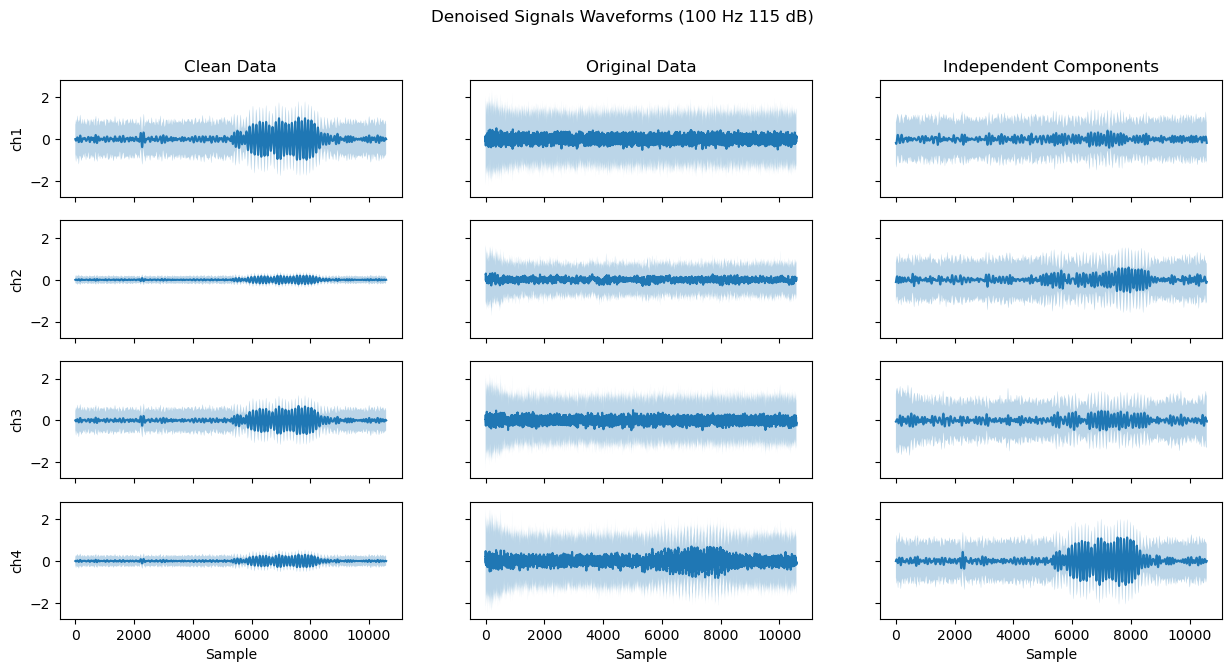

In [189]:
fig, axes = plt.subplots(4, 3, figsize=(15, 7), sharex=True, sharey=True)
channels = ['ch1', 'ch2', 'ch3', 'ch4']
x = np.arange(len(ICA_dict['ch1_mean']))

for row, channel in enumerate(channels):
    # Extract data for this channel
    mean_data_clean = ICA_dict[f'{channel}_mean']
    std_data_clean = ICA_dict[f'{channel}_std']
    
    mean_data_orig = orig_dict[f'{channel}_mean']
    std_data_orig = orig_dict[f'{channel}_std']
    
    mean_data_load = load_dict[f'{channel}_mean']
    std_data_load = load_dict[f'{channel}_std']
    
    # Plot clean data (left column)
    axes[row, 0].plot(x, mean_data_clean)
    axes[row, 0].fill_between(x, 
                               mean_data_clean - std_data_clean, 
                               mean_data_clean + std_data_clean, 
                               alpha=0.3)
    axes[row, 0].set_ylabel(f'{channel}')
    
    
    # Plot original data (right column)
    axes[row, 1].plot(x, mean_data_orig,)
    axes[row, 1].fill_between(x, 
                               mean_data_orig - std_data_orig, 
                               mean_data_orig + std_data_orig, 
                               alpha=0.3)
    
    
    # Plot original data (right column)
    axes[row, 2].plot(x, mean_data_load)
    axes[row, 2].fill_between(x, 
                            mean_data_load - std_data_load, 
                            mean_data_load + std_data_load, 
                            alpha=0.3)
    

# Add column titles
axes[0, 0].set_title('Clean Data')
axes[0, 1].set_title('Original Data')
axes[0, 2].set_title('Independent Components')

# Add x-label to bottom row
axes[3, 0].set_xlabel('Sample')
axes[3, 1].set_xlabel('Sample')
axes[3, 2].set_xlabel('Sample')

fig.suptitle(f'Denoised Signals Waveforms ({myfreq} Hz {myamp} dB)')
plt.savefig(f'{subjid}_{myfreq}Hz_{myamp}dB_chart9.png', dpi=300, bbox_inches='tight')
plt.show()

### Calculate Comparison FFTs

In [190]:
np.fft.rfft(ICA_dict[f'{channel}_mean'][latency:latency+period_len])

array([ 1.2137771 +0.00000000e+00j,  1.1381001 -4.90295533e-02j,
        1.13930791-9.85949256e-02j, ..., -0.03279432+5.56861503e-05j,
       -0.03279431+2.78430530e-05j, -0.03279431+0.00000000e+00j],
      shape=(1765,))

In [191]:
# Calculate FFT and power spectrum for each component
n_samples = len(ICA_dict['ch1_mean'])
period_len = current_cond['period_len']
# Get positive frequencies only
freqs = np.fft.rfftfreq(n_samples, d=1/fs)
# Calculate power spectrum for each component

# cleaned data
clean_spectra_mean = []
clean_spectra_std = []

clean_spectra_prestim_mean = []
clean_spectra_prestim_std = []

clean_spectra_stimresp_mean = []
clean_spectra_stimresp_std = []

# mean
for channel in channel_keys:
    fft_vals = np.fft.rfft(ICA_dict[f'{channel}_mean'])
    power = np.abs(fft_vals) ** 2
    clean_spectra_mean.append(power)

# std
for channel in channel_keys:
    fft_vals = np.fft.rfft(ICA_dict[f'{channel}_std'])
    power = np.abs(fft_vals) ** 2
    clean_spectra_std.append(power)

# prestim mean
for channel in channel_keys:
    fft_vals = np.fft.rfft(ICA_dict[f'{channel}_mean'][latency:latency+period_len])
    power = np.abs(fft_vals) ** 2
    clean_spectra_prestim_mean.append(power)

# prestim std
for channel in channel_keys:
    fft_vals = np.fft.rfft(ICA_dict[f'{channel}_std'][latency:latency+period_len])
    power = np.abs(fft_vals) ** 2
    clean_spectra_prestim_std.append(power)

# stimresp mean
for channel in channel_keys:
    fft_vals = np.fft.rfft(ICA_dict[f'{channel}_mean'][latency+period_len:latency+period_len*2])
    power = np.abs(fft_vals) ** 2
    clean_spectra_stimresp_mean.append(power)

# stimresp std
for channel in channel_keys:
    fft_vals = np.fft.rfft(ICA_dict[f'{channel}_std'][latency+period_len:latency+period_len*2])
    power = np.abs(fft_vals) ** 2
    clean_spectra_stimresp_std.append(power)


#######


# original data

orig_spectra_mean = []
orig_spectra_std = []

orig_spectra_prestim_mean = []
orig_spectra_prestim_std = []

orig_spectra_stimresp_mean = []
orig_spectra_stimresp_std = []

# mean
for channel in channel_keys:  # iterate through each component
    fft_vals = np.fft.rfft(orig_dict[f'{channel}_mean'])
    power = np.abs(fft_vals) ** 2
    orig_spectra_mean.append(power)
   
# std
for channel in channel_keys:  # iterate through each component
    fft_vals = np.fft.rfft(orig_dict[f'{channel}_std'])
    power = np.abs(fft_vals) ** 2
    orig_spectra_std.append(power)
    
# prestim mean
for channel in channel_keys:
    fft_vals = np.fft.rfft(orig_dict[f'{channel}_mean'][latency:latency+period_len])
    power = np.abs(fft_vals) ** 2
    orig_spectra_prestim_mean.append(power)

# prestim std
for channel in channel_keys:
    fft_vals = np.fft.rfft(orig_dict[f'{channel}_std'][latency:latency+period_len])
    power = np.abs(fft_vals) ** 2
    orig_spectra_prestim_std.append(power)

# stimresp mean
for channel in channel_keys:
    fft_vals = np.fft.rfft(orig_dict[f'{channel}_mean'][latency+period_len:latency+period_len*2])
    power = np.abs(fft_vals) ** 2
    orig_spectra_stimresp_mean.append(power)

# stimresp std
for channel in channel_keys:
    fft_vals = np.fft.rfft(orig_dict[f'{channel}_std'][latency+period_len:latency+period_len*2])
    power = np.abs(fft_vals) ** 2
    orig_spectra_stimresp_std.append(power)



#########

# loading data
# mean
load_spectra_mean = []
load_spectra_std = []

load_spectra_prestim_mean = []
load_spectra_prestim_std = []

load_spectra_stimresp_mean = []
load_spectra_stimresp_std = []

for channel in channel_keys:  # iterate through each component
    fft_vals = np.fft.rfft(load_dict[f'{channel}_mean'])
    power = np.abs(fft_vals) ** 2
    load_spectra_mean.append(power)
   
# std
for channel in channel_keys:  # iterate through each component
    fft_vals = np.fft.rfft(load_dict[f'{channel}_std'])
    power = np.abs(fft_vals) ** 2
    load_spectra_std.append(power)
    
# prestim mean
for channel in channel_keys:
    fft_vals = np.fft.rfft(load_dict[f'{channel}_mean'][latency:latency+period_len])
    power = np.abs(fft_vals) ** 2
    load_spectra_prestim_mean.append(power)

# prestim std
for channel in channel_keys:
    fft_vals = np.fft.rfft(load_dict[f'{channel}_std'][latency:latency+period_len])
    power = np.abs(fft_vals) ** 2
    load_spectra_prestim_std.append(power)

# stimresp mean
for channel in channel_keys:
    fft_vals = np.fft.rfft(load_dict[f'{channel}_mean'][latency+period_len:latency+period_len*2])
    power = np.abs(fft_vals) ** 2
    load_spectra_stimresp_mean.append(power)

# stimresp std
for channel in channel_keys:
    fft_vals = np.fft.rfft(load_dict[f'{channel}_std'][latency+period_len:latency+period_len*2])
    power = np.abs(fft_vals) ** 2
    load_spectra_stimresp_std.append(power)

# Convert to array for easier handling
# cleaned data
# mean
clean_spectra_mean = np.array(clean_spectra_mean)
clean_spectra_std = np.array(clean_spectra_std)

clean_spectra_prestim_mean = np.array(clean_spectra_prestim_mean)
clean_spectra_prestim_std = np.array(clean_spectra_prestim_std)

clean_spectra_stimresp_mean = np.array(clean_spectra_stimresp_mean)
clean_spectra_stimresp_std = np.array(clean_spectra_stimresp_std)

# original data
orig_spectra_mean = np.array(orig_spectra_mean)
orig_spectra_std = np.array(orig_spectra_std)

orig_spectra_prestim_mean = np.array(orig_spectra_prestim_mean)
orig_spectra_prestim_std = np.array(orig_spectra_prestim_std)

orig_spectra_stimresp_mean = np.array(orig_spectra_stimresp_mean)
orig_spectra_stimresp_std = np.array(orig_spectra_stimresp_std)

# loading data
load_spectra_mean = np.array(load_spectra_mean)
load_spectra_std = np.array(load_spectra_std)  # shape: (4, n_freqs)

load_spectra_prestim_mean = np.array(load_spectra_prestim_mean)
load_spectra_prestim_std = np.array(load_spectra_prestim_std)

load_spectra_stimresp_mean = np.array(load_spectra_stimresp_mean)
load_spectra_stimresp_std = np.array(load_spectra_stimresp_std)

### Plot comparison FFTs

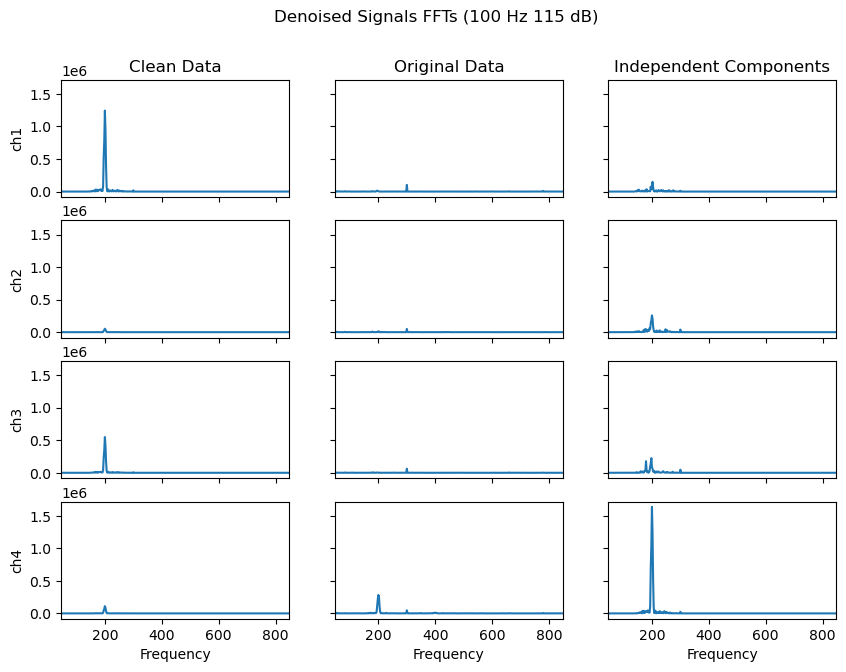

In [192]:
fig, axes = plt.subplots(4, 3, figsize=(10, 7), sharex=True, sharey=True)
channels = ['ch1', 'ch2', 'ch3', 'ch4']
x = np.arange(len(ICA_dict['ch1_mean']))

for row, channel in enumerate(channels):
    # Extract data for this channel
    mean_data_clean = clean_spectra_mean[row,:]
    std_data_clean = clean_spectra_std[row,:]
    
    mean_data_orig = orig_spectra_mean[row,:]
    std_data_orig = orig_spectra_std[row,:]
    
    mean_data_load = load_spectra_mean[row,:]
    std_data_load = load_spectra_std[row,:]
    
    # Plot clean data (left column)
    axes[row, 0].plot(freqs, mean_data_clean)
    axes[row, 0].set_ylabel(f'{channel}')

    # Plot original data (right column)
    axes[row, 1].plot(freqs, mean_data_orig,)

    # Plot original data (right column)
    axes[row, 2].plot(freqs, mean_data_load)
    
    
    # Add these lines inside your plotting loop
    axes[row, 0].set_xlim(low/1.5, high*1.5)
    axes[row, 1].set_xlim(low/1.5, high*1.5)
    axes[row, 2].set_xlim(low/1.5, high*1.5)
    
    # # Add these lines inside your plotting loop
    # axes[row, 0].set_ylim(0, 100000)
    # axes[row, 1].set_ylim(0, 100000)

    




# Add column titles
axes[0, 0].set_title('Clean Data')
axes[0, 1].set_title('Original Data')
axes[0, 2].set_title('Independent Components')

# Add x-label to bottom row
axes[3, 0].set_xlabel('Frequency')
axes[3, 1].set_xlabel('Frequency')
axes[3, 2].set_xlabel('Frequency')


fig.suptitle(f'Denoised Signals FFTs ({myfreq} Hz {myamp} dB)')
plt.savefig(f'{subjid}_{myfreq}Hz_{myamp}dB_chart10.png', dpi=300, bbox_inches='tight')
plt.show()

### Calculate the t-statistic for prestim vs. stim resp of the cleaned data vs. noisy data